Importar librerias y leer inputs

In [157]:
# Importar Librerias
import pandas as pd
import matplotlib.pyplot as plt

In [104]:
# Leer conjunto de datsets
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
categories = pd.read_csv("data/product_category_name_translation.csv")

Limpieza de datos

In [105]:
# Filtrar solo ordenes entregadas
orders = orders[orders["order_status"] == "delivered"]

In [106]:
# Seleccionar solo las columnas que nos interesan
orders = orders[
    ["order_id", "order_purchase_timestamp"]
]

order_items = order_items[
    ["order_id", "product_id", "price", "freight_value"]
]

products = products[
    ["product_id", "product_category_name"]
]

In [107]:
# Unir datasets
df = orders.merge(order_items,on="order_id",how="inner")
df = df.merge(products,on="product_id",how="left")
df = df.merge(categories,on="product_category_name",how="left")

In [108]:
# Convertir columna fecha
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

In [109]:
#Se conservan los duplicados ya que significa que el producto se compró más de una vez
df.duplicated().sum()

np.int64(10001)

In [110]:
# Ver nulos
df.isnull().sum()

order_id                            0
order_purchase_timestamp            0
product_id                          0
price                               0
freight_value                       0
product_category_name            1537
product_category_name_english    1559
dtype: int64

In [111]:
# Rellenar nulos en categoria
df["product_category_name_english"] = df["product_category_name_english"].fillna("unknown")

In [112]:
# seleccionar columnas
df_final = df[
    [
        "order_purchase_timestamp",
        "order_id",
        "product_id",
        "product_category_name_english",
        "price",
        "freight_value"
    ]
]

In [113]:
## guardar tabla
df_final.to_csv("tabla_analitica_olist.csv", index=False)

Crear tabla de demanda diaria

In [159]:
df_final = pd.read_csv("tabla_analitica_olist.csv")

In [160]:
df_final.head()

,order_purchase_timestamp,order_id,product_id,product_category_name_english,price,freight_value
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,housewares,29.99,8.72
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,perfumery,118.70,22.76
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,auto,159.90,19.22
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,45.00,27.20
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,stationery,19.90,8.72


In [114]:
df_final["date"] = df_final["order_purchase_timestamp"].dt.date

demanda_diaria  = (
    df_final
    .groupby(["date", "product_id", "product_category_name_english"])
    .agg(
        quantity=("product_id", "count"),
        total_sales=("price", "sum")
    )
    .reset_index()
)

In [115]:
demanda_diaria.head(10)

,date,product_id,product_category_name_english,quantity,total_sales
0,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3,134.97
1,2016-10-03,107177bf61755f05c604fe57e02467d6,furniture_decor,1,119.90
2,2016-10-03,3ae08df6bcbfe23586dd431c40bddbb7,watches_gifts,1,29.90
3,2016-10-03,a5c3ddb1a400f50d1cf7138727aec136,toys,1,128.90
4,2016-10-03,b72b39418216e944bb34e35f4d3ea8c7,sports_leisure,1,36.49
5,2016-10-03,bfce5e847034e1fbbc1ed0bff6a372c7,furniture_decor,1,74.90
6,2016-10-03,e2a1d45a73dc7f5a7f9236b043431b89,fashion_shoes,1,29.99
7,2016-10-03,fd7fd78fd3cbc1b0a6370a7909c0a629,sports_leisure,1,21.90
8,2016-10-04,062619359d5f9a664606cb2a6ccb477a,health_beauty,1,136.90
9,2016-10-04,0c5801458e74f9b6c23b44c331426e30,cool_stuff,1,89.90


In [116]:
demanda_diaria.shape

(92587, 5)

In [117]:
demanda_diaria.info()

<class 'pandas.DataFrame'>
RangeIndex: 92587 entries, 0 to 92586
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           92587 non-null  object 
 1   product_id                     92587 non-null  str    
 2   product_category_name_english  92587 non-null  str    
 3   quantity                       92587 non-null  int64  
 4   total_sales                    92587 non-null  float64
dtypes: float64(1), int64(1), object(1), str(2)
memory usage: 3.5+ MB


Crear tabla con demanda semanal

In [118]:
demanda_semanal = demanda_diaria.copy()

demanda_semanal["date"] = pd.to_datetime(demanda_semanal["date"])

demanda_semanal["week"] = (
    demanda_semanal["date"]
    .dt.to_period("W")
    .dt.start_time
)

demanda_semanal = (
    demanda_semanal
    .groupby(
        ["week", "product_id", "product_category_name_english"],
        as_index=False
    )
    .agg(weekly_quantity=("quantity", "sum"))
)

In [119]:
demanda_semanal.head(10)

,week,product_id,product_category_name_english,weekly_quantity
0,2016-09-12,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3
1,2016-10-03,027cdd14a677a5834bc67a9789db5021,perfumery,1
2,2016-10-03,0534940d69bf94dc61c0e722b4168235,furniture_decor,1
3,2016-10-03,05fca08b4d54ab5d1d371db7d5534136,computers_accessories,1
4,2016-10-03,062619359d5f9a664606cb2a6ccb477a,health_beauty,1
5,2016-10-03,0980718a7bdcf89f5848b202b6394965,health_beauty,1
6,2016-10-03,09b590ada623ecf66329917ea4731957,watches_gifts,1
7,2016-10-03,0ab80f38a21093b448518f68efe82c24,housewares,1
8,2016-10-03,0b230f10ac2cfc4c831b825bf31a5de2,pet_shop,1
9,2016-10-03,0c5801458e74f9b6c23b44c331426e30,cool_stuff,1


In [120]:
demanda_semanal.shape

(77713, 4)

In [121]:
demanda_semanal.info()

<class 'pandas.DataFrame'>
RangeIndex: 77713 entries, 0 to 77712
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   week                           77713 non-null  datetime64[us]
 1   product_id                     77713 non-null  str           
 2   product_category_name_english  77713 non-null  str           
 3   weekly_quantity                77713 non-null  int64         
dtypes: datetime64[us](1), int64(1), str(2)
memory usage: 2.4 MB


In [123]:

demanda_semanal["weekly_quantity"].describe()

count    77713.000000
mean         1.418000
std          1.381524
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         59.000000
Name: weekly_quantity, dtype: float64

In [ ]:
## Rango de semanas
demanda_semanal["week"].min(), demanda_semanal["week"].max()

(Timestamp('2016-09-12 00:00:00'), Timestamp('2018-08-27 00:00:00'))

Análisis Univariado

  Product Id

In [ ]:
demanda_semanal["product_id"].nunique()

32216

  Product Category

In [ ]:
## ver cantidad de valores unicos
demanda_semanal["product_category_name_english"].nunique()


72

In [135]:
## Ver valores unicos
demanda_semanal["product_category_name_english"].drop_duplicates().head(10)

0             health_beauty
1                 perfumery
2           furniture_decor
3     computers_accessories
6             watches_gifts
7                housewares
8                  pet_shop
9                cool_stuff
10           sports_leisure
15                     auto
Name: product_category_name_english, dtype: str

 Date

In [ ]:
## Rango de fechas
demanda_diaria['date'].min(),demanda_diaria['date'].max()

(datetime.date(2016, 9, 15), datetime.date(2018, 8, 29))

Análsis Bivariado

In [ ]:
## Productos con mayor demanda semanal
demanda_semanal.groupby(
    "product_id"
)["weekly_quantity"].sum().sort_values(ascending=False).head(10)

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    520
422879e10f46682990de24d770e7f83d    484
99a4788cb24856965c36a24e339b6058    477
389d119b48cf3043d311335e499d9c6b    390
368c6c730842d78016ad823897a372db    388
53759a2ecddad2bb87a079a1f1519f73    373
d1c427060a0f73f6b889a5c7c61f2ac4    332
53b36df67ebb7c41585e8d54d6772e08    321
154e7e31ebfa092203795c972e5804a6    274
3dd2a17168ec895c781a9191c1e95ad7    272
Name: weekly_quantity, dtype: int64

In [151]:
#Categoria con mayor demanda semanal
top_10_categorias = (
    demanda_semanal
    .groupby("product_category_name_english", as_index=False)
    .agg(total_weekly_quantity=("weekly_quantity", "sum"))
    .sort_values("total_weekly_quantity", ascending=False)
    .head(10)
)
top_10_categorias

,product_category_name_english,total_weekly_quantity
7,bed_bath_table,10953
43,health_beauty,9465
65,sports_leisure,8431
39,furniture_decor,8160
15,computers_accessories,7644
49,housewares,6795
71,watches_gifts,5859
68,telephony,4430
42,garden_tools,4268
5,auto,4140


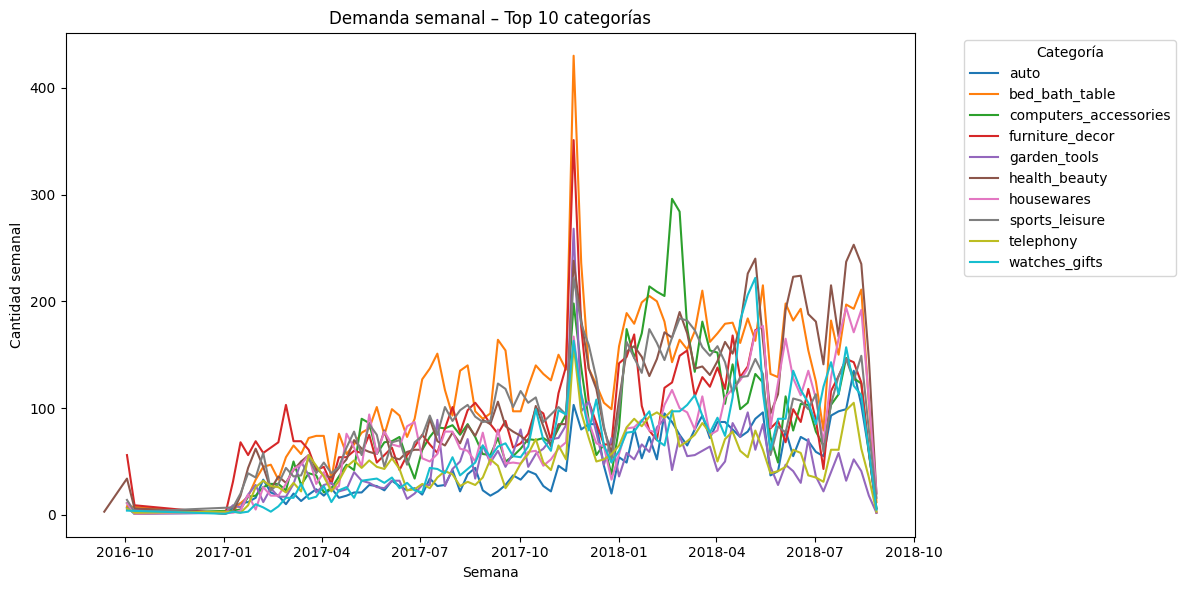

In [158]:
## Serie de tiempo de top 10 Categorias con mayor demanda

lista_top_10_categorias = (top_10_categorias["product_category_name_english"].tolist())
demanda_top_10 = demanda_semanal[demanda_semanal["product_category_name_english"].isin(lista_top_10_categorias)]

demanda_top_10 = (
    demanda_top_10.groupby(["week", "product_category_name_english"],as_index=False)
    .agg(total_weekly_quantity=("weekly_quantity", "sum")).sort_values(by="week")
)

plt.figure(figsize=(12, 6))

for categoria, df_cat in demanda_top_10.groupby("product_category_name_english"):
    plt.plot(
        df_cat["week"],
        df_cat["total_weekly_quantity"],
        label=categoria
    )

plt.xlabel("Semana")
plt.ylabel("Cantidad semanal")
plt.title("Demanda semanal – Top 10 categorías")
plt.legend(title="Categoría", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()